In [1]:
# Import packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import matplotlib.pylab as pylab
import glob
import os
from numpy.random import seed
from scipy.stats import gamma
import pymc3 as pm

In [2]:
# Prior notebook ends with a csv save of train_master dataset.
train_csv = "../train_master.csv"
dates = ['TIME_SCHEDULED',
         'ARRIVAL',
         'DEPARTURE',
         'Date',
         'SURVEY_DATE_EFFECTIVE',
         'BRONCOS_TIME']
trains = pd.read_csv(train_csv,
                    header=0,
                     sep=',',
                     index_col=0,
                     infer_datetime_format=True,
                     parse_dates=dates)
trains.info(verbose=True, null_counts=True)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (49,50,51,52,53,54,55,56,57,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843234 entries, 0 to 1843233
Data columns (total 103 columns):
SERIAL_NUMBER                           1843234 non-null int64
SCHEDULE_NAME                           1843234 non-null object
SIGNUP_NAME                             1843234 non-null object
SURVEY_SOURCE                           1843234 non-null int64
PATTERN_ID                              1843234 non-null int64
BRANCH                                  1843234 non-null object
ROUTE_NUMBER                            1843234 non-null int64
ROUTE_NAME                              1843234 non-null object
DIRECTION_NAME                          1843234 non-null object
SERVICE_TYPE                            1843234 non-null object
SERVICE_MODE                            1841366 non-null object
SURVEY_DATE_EFFECTIVE                   1843234 non-null datetime64[ns]
SURVEY_DATE_ATYPICAL                    1843234 non-null int64
TIME_PERIOD                             1843234 non

# Evaluate Difference of Mean Delays between 'Good Weather' and "Bad Weather"

In [3]:
# Define good weather as departures wherein Snow and Hail/Ice were not present.
snow_ice_delays = trains['DEPARTURE_DELAY'].loc[(trains['Light Freezing Drizzle/Freezing Rain']==1) | 
                                                    (trains['Light Snow']==1) | 
                                                    (trains['Snow'] == 1) |
                                                    (trains['Heavy Snow'] == 1) |
                                                    (trains['Blowing Or Drifting Snow']==1) |
                                                    (trains['Freezing Drizzle/Freezing Rain']==1) | 
                                                    (trains['Light Freezing Rain']==1) | 
                                                    (trains['Hail Showers'] == 1)]
good_weather_delays = trains['DEPARTURE_DELAY'].loc[(trains['Light Freezing Drizzle/Freezing Rain']==0) &
                                                    (trains['Light Snow']==0) & 
                                                    (trains['Snow'] == 0) &
                                                    (trains['Heavy Snow'] == 0) &
                                                    (trains['Blowing Or Drifting Snow'] ==0) &
                                                    (trains['Freezing Drizzle/Freezing Rain'] ==0) & 
                                                    (trains['Light Freezing Rain'] ==0) & 
                                                    (trains['Hail Showers'] == 0)]

In [4]:
def bootstrap_replicate(data, func,size=1):
    """Draw bootstrap samples of equal length of data and create a distribution of bootstrap mean replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data,size=len(data)))
    return bs_replicates

In [6]:
# Create mean bootstrap replicates of each subsection of delays.
np.random.seed(13)
good_weather_replicates = bootstrap_replicate(good_weather_delays,np.mean,50000)
snow_ice_replicates = bootstrap_replicate(snow_ice_delays,np.mean,50000)

In [7]:
# Gather a bootstrapped difference of means and its resulting confidence interval
diff_of_means = snow_ice_replicates - good_weather_replicates
CI = np.percentile(diff_of_means,[2.5,97.5])
print("95% Confidence Interval: "+str(CI))

95% Confidence Interval: [35.82728009 39.10296803]


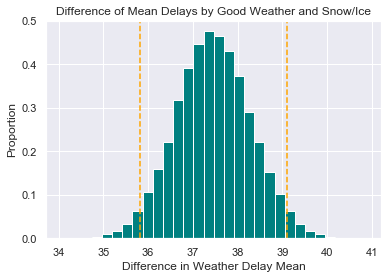

In [10]:
# Plot the difference of bootstrapped means with a 95% confidence interval.
_ = plt.hist(diff_of_means, density=True, bins=30,color='teal')
_ = plt.title('Difference of Mean Delays by Good Weather and Snow/Ice')
_ = plt.xlabel('Difference in Weather Delay Mean')
_ = plt.ylabel('Proportion')
_ = plt.axvline(x=CI[0], c='orange', linestyle='--')
_ = plt.axvline(x=CI[1], c='orange', linestyle='--')
plt.show()

Since the 95% confidence interval does not near 0, snow/icy departures are delayed more than non-snowy/icy days.

# Compare Southbound train delays with other other directions

In [ ]:
def permutation_samples(data1, data2):
    """Generate 2 permutated samples from 2 provided arrays."""
    
    # Concatenate datasets
    combined = np.concatenate((data1, data2))
    # Permute combined dataset
    permuted_combined = np.random.permutation(combined)
    # Create 2 randomized samples for comparison
    perm_1 = permuted_combined[:len(data1)]
    perm_2 = permuted_combined[len(data1):]
    
    return perm_1, perm_2

def permutation_replicates(data1, data2, func, size=1):
    """Generate permutated replicates"""
    
    # Create empty array for replicate values
    replicates = np.empty(size)
    
    for i in range(size):
        # Generate permutation samples using permutation_samples function
        sample_1, sample_2 = permutation_samples(data1, data2)
        
        # Compute replicates using provided func
        replicates[i] = func(sample_1, sample_2)
    
    return replicates

def diff_of_means(data1, data2):
    """Generate difference in function of 2 arrays."""
    
    diff = np.mean(data1) - np.mean(data2)
    return diff

In [ ]:
# Create array of delays for southbound and non-southbound trains
south = trains['DEPARTURE_DELAY'].loc[trains.DIRECTION_NAME == 'south']
other_directions = trains['DEPARTURE_DELAY'].loc[trains.DIRECTION_NAME != 'south']

# Create bootstrap replicates of differences of means
bs_diff = permutation_replicates(south, other_directions,diff_of_means,size=10000)
emp_diff = diff_of_means(south,other_directions)

p_value = np.sum(bs_diff >= emp_diff)/len(bs_diff)

print(p_value)

P-value of 0 indicates that a null hypothesis of southbound trains have equal average delays to other directions should be rejected and alternative hypothesis accepted.

# Evaluate and attempt to simulate delays departure distribution

In [ ]:
# Evaluate distribution of delays. Could the distribution be exponential and defined by an alpha and beta?
plt.figure(figsize=(15,15))
sns.distplot(trains['DEPARTURE_DELAY'],
            bins = 100,
            hist=True,
            norm_hist=True)
plt.xlabel('Seconds Delayed')
plt.show()

In [ ]:
delays = trains['DEPARTURE_DELAY'].loc[trains['END_OF_LINE']==1]
n_delays = len(delays)

alpha_est = np.mean(delays)**2 / np.var(delays)
beta_est = np.var(delays) / np.mean(delays)
alpha_est, beta_est

simulated = gamma(alpha_est, scale=beta_est).rvs(n_delays)

plt.figure(figsize=(12,12))
_ = plt.hist(simulated, bins=50, alpha=0.9, label='simulated', density=True)
_ = plt.hist(delays, bins=50, alpha=0.5, label='observed',density=True)
_ = plt.xlabel('Delay')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [ ]:
# PyMC3 Gamma uses rate = 1/beta
rate_est = 1/beta_est

In [ ]:
with pm.Model() as model:
    # Create exponential prior for alpha: alpha_
    alpha_ = pm.Exponential("alpha", 1/alpha_est)
    
    # Create exponential prior for rate (1/beta): rate_ 
    rate_ = pm.Exponential("beta", 1/rate_est)
    
    # Create gamma distribution with prior and observed inputs: charge_no_ins
    bayesian_delays = pm.Gamma("bayesian_delays", alpha=alpha_, beta=rate_, observed=delays)
    print(model.check_test_point())
    #trace = pm.sample(1000, cores=2, chains=2)

In [ ]:
alpha_samples = trace['alpha']
beta_samples = trace['beta']

# Calculate 95% credible interval for alpha and beta
alpha_CI = np.percentile(alpha_samples,[2.5,97.5])
print("alpha 95% credible interval: "+str(alpha_CI))
beta_CI = np.percentile(beta_samples,[2.5,97.5])
print("beta 95% credible interval: "+str(beta_CI))

_ = pm.plots.plot_posterior(data=trace,var_names=["alpha","beta"])